# VISDOM Feature Creation
Clayton Miller - miller.clayton@gmail.com

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import timeit
import os
from datetime import datetime
from __future__ import division
import matplotlib.dates as mdates
from matplotlib import ticker
import datetime
import matplotlib

In [2]:
import rpy2

In [3]:
sns.set_style("whitegrid")

In [4]:
%matplotlib inline

In [5]:
%load_ext rpy2.ipython 

In [6]:
from pylab import *

In [7]:
repos_path = "/Users/Clayton/temporal-features-for-buildings/"

In [8]:
meta = pd.read_csv(os.path.join(repos_path,"data/raw/meta_open.csv"), index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)

In [9]:
temp = pd.read_csv((os.path.join(repos_path,"data/interim/temp_open_utc_complete.csv")), index_col='timestamp', parse_dates=True).tz_localize('utc')

# Create a 1 building example of a Visdom Data Source and Feature Extraction

First, we need to create a custom DataSource for our data to be passed to R

In [10]:
%%R 
library(visdom)
library(plyr)

/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘visdom’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/Clayton/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [11]:
building = "UnivClass_Clifford"

In [12]:
timezone = meta.T[building].timezone
start = meta.T[building].datastart
end = meta.T[building].dataend
building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
weatherfilename = meta.T[building].newweatherfilename
weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
#weather = weather.tz_localize(timezone, ambiguous = 'infer')
outdoor_temp_index = pd.DatetimeIndex(start=str(start.date()), freq='H', periods=len(building_data))
outdoor_temp = pd.DataFrame(weather[[col for col in weather.columns if 'Temperature' in col]]).resample("H").mean()
outdoor_temp = outdoor_temp.reindex(outdoor_temp_index)

In [13]:
outdoor_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
TemperatureC    8565 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [14]:
outdoor_temp = outdoor_temp.ffill()

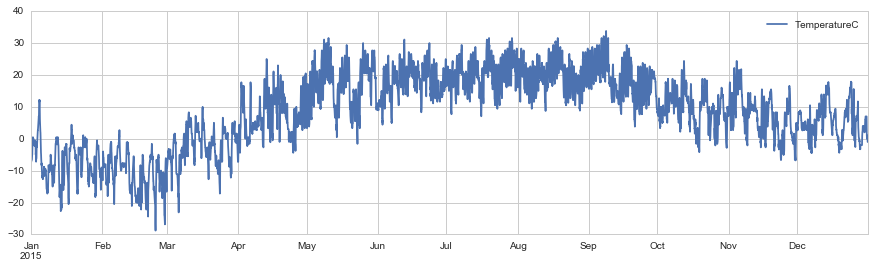

In [15]:
outdoor_temp.plot(figsize=(15,4));

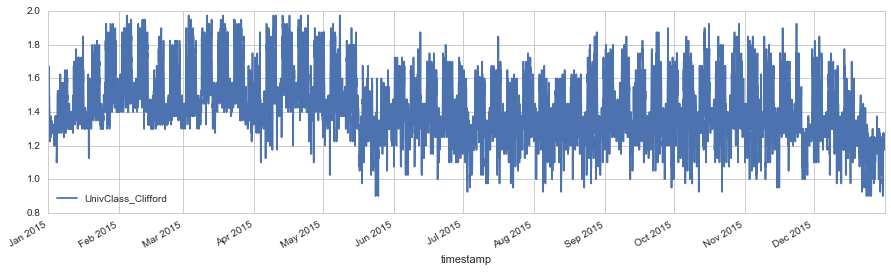

In [16]:
building_data.plot(figsize=(15,4));

In [17]:
outdoor_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-01-01 00:00:00 to 2015-12-31 23:00:00
Freq: H
Data columns (total 1 columns):
TemperatureC    8760 non-null float64
dtypes: float64(1)
memory usage: 136.9 KB


In [18]:
building_data['Time'] = building_data.index.map(lambda t: t.time())
building_data['Date'] = building_data.index.map(lambda t: t.date())

In [19]:
building_data.head()

,UnivClass_Clifford,Time,Date
timestamp,,,
2015-01-01 00:00:00-05:00,1.3700,00:00:00,2015-01-01
2015-01-01 01:00:00-05:00,1.3550,01:00:00,2015-01-01
2015-01-01 02:00:00-05:00,1.3275,02:00:00,2015-01-01
2015-01-01 03:00:00-05:00,1.3350,03:00:00,2015-01-01
2015-01-01 04:00:00-05:00,1.3700,04:00:00,2015-01-01


In [20]:
dailyblocks = pd.pivot_table(building_data, values=building, index='Date', columns='Time', aggfunc='mean').ffill()

In [21]:
dailyblocks.head()

Time,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1.370,1.355,1.3275,1.335,1.370,1.3875,1.3825,1.410,1.465,1.5175,...,1.6725,1.625,1.5575,1.5325,1.4925,1.465,1.43,1.3975,1.375,1.3625
2015-01-02,1.250,1.275,1.2250,1.300,1.300,1.2750,1.2750,1.275,1.275,1.2500,...,1.3000,1.300,1.3250,1.3000,1.3500,1.325,1.30,1.3250,1.275,1.2750
2015-01-03,1.325,1.300,1.3000,1.300,1.325,1.3250,1.3000,1.275,1.300,1.2750,...,1.3000,1.300,1.3000,1.3250,1.3250,1.250,1.30,1.2000,1.300,1.2750
2015-01-04,1.275,1.275,1.2250,1.200,1.300,1.3000,1.3000,1.300,1.325,1.3000,...,1.3250,1.375,1.3250,1.3750,1.3000,1.300,1.30,1.3000,1.325,1.1000
2015-01-05,1.125,1.125,1.3000,1.300,1.325,1.3000,1.3000,1.450,1.500,1.5000,...,1.4500,1.525,1.5250,1.4500,1.4500,1.300,1.30,1.2750,1.300,1.3000


In [22]:
len(dailyblocks)

365

In [23]:
rawdata = dailyblocks.reset_index(drop=True).T.reset_index(drop=True).T

In [24]:
rawdata.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,1.370,1.355,1.3275,1.335,1.370,1.3875,1.3825,1.410,1.465,1.5175,...,1.6725,1.625,1.5575,1.5325,1.4925,1.465,1.43,1.3975,1.375,1.3625
1,1.250,1.275,1.2250,1.300,1.300,1.2750,1.2750,1.275,1.275,1.2500,...,1.3000,1.300,1.3250,1.3000,1.3500,1.325,1.30,1.3250,1.275,1.2750
2,1.325,1.300,1.3000,1.300,1.325,1.3250,1.3000,1.275,1.300,1.2750,...,1.3000,1.300,1.3000,1.3250,1.3250,1.250,1.30,1.2000,1.300,1.2750
3,1.275,1.275,1.2250,1.200,1.300,1.3000,1.3000,1.300,1.325,1.3000,...,1.3250,1.375,1.3250,1.3750,1.3000,1.300,1.30,1.3000,1.325,1.1000
4,1.125,1.125,1.3000,1.300,1.325,1.3000,1.3000,1.450,1.500,1.5000,...,1.4500,1.525,1.5250,1.4500,1.4500,1.300,1.30,1.2750,1.300,1.3000


In [25]:
numberofdays = len(rawdata)

In [26]:
numberofdays

365

In [27]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 24 columns):
0     365 non-null float64
1     365 non-null float64
2     365 non-null float64
3     365 non-null float64
4     365 non-null float64
5     365 non-null float64
6     365 non-null float64
7     365 non-null float64
8     365 non-null float64
9     365 non-null float64
10    365 non-null float64
11    365 non-null float64
12    365 non-null float64
13    365 non-null float64
14    365 non-null float64
15    365 non-null float64
16    365 non-null float64
17    365 non-null float64
18    365 non-null float64
19    365 non-null float64
20    365 non-null float64
21    365 non-null float64
22    365 non-null float64
23    365 non-null float64
dtypes: float64(24)
memory usage: 68.5 KB


In [28]:
outdoordrybulb = np.array(outdoor_temp.reset_index(drop=True).T.reset_index(drop=True).T)

In [29]:
outdoordrybulb

array([[-7.2],
       [-6.6],
       [-6.6],
       ..., 
       [-1. ],
       [-1. ],
       [-1. ]])

In [30]:
building

'UnivClass_Clifford'

In [31]:
begindate = str(start.date())
enddate = str(end.date())

In [32]:
enddate

'2015-12-31'

In [33]:
%Rpush building
%Rpush begindate
%Rpush enddate
%Rpush timezone
%Rpush rawdata
%Rpush outdoordrybulb
%Rpush numberofdays

In [34]:
%R rawdata <- as.matrix(rawdata)
%R outdoordrybulb <- c(outdoordrybulb)
%R ids <- c(building)
%R customerIDs <- c(building)

array(['UnivClass_Clifford'], 
      dtype='|S18')

In [35]:
#%R print(rawdata)

In [36]:
%%R
LoadTemporalData = function(n=1, ids, customerIDs, begindate, timezone, rawdata, outdoordrybulb, numberofdays) {
    obj = DataSource( )

    obj$n = n

    obj$getHourlyAlignedData = function( n=NULL ) {
    if(is.null(n)) { n = obj$n }
    dates = as.Date(begindate) + 0:(numberofdays - 1)
    data = data.frame(  id         = rep(ids,each=numberofdays),
                        customerID = rep(customerIDs,each=numberofdays),
                        geocode    = '99999',
                        dates      = rep(dates,n))

    data$id         = as.character(data$id)
    data$customerID = as.character(data$customerID)
    data$geocode = as.character(data$geocode)

    obs = rawdata
    data = cbind(data,obs)
    names(data)[5:28] = paste('H',1:24,sep='')
    return(data)
    }

    obj$getAllData = function(geocode,useCache=T) {
    return( obj$getHourlyAlignedData( ) )
    }

    obj$getMeterData = function(id, geo=NULL) {
    return( obj$getHourlyAlignedData( n=1 ) )
    }

    obj$getIds = function(geocode,useCache=T) {
    return( unique(obj$getHourlyAlignedData()$id ) )
    }

    obj$getGeoForId = function(id) {
    return('99999')
    }

    obj$getWeatherData = function( geocode, useCache=T ) {
    dates = as.POSIXct(begindate, tz=timezone) + 0:(numberofdays * 24 - 1) * 3600
    data = data.frame(
      dates        = dates,
      temperaturef = rep( c(outdoordrybulb)),
        #Left these in here for now -- need to load these data from the weather files....
      pressure     = rep( rep(19,24), numberofdays ),
      hourlyprecip = rep( c( rep(0,12),rep(1,2),rep(0,10) ), numberofdays ),
      dewpointf    = rep( rep(55,24), numberofdays )
    )

    return(data)
    }

    class(obj) = append(class(obj),"TestData")

  return(obj)
}

In [37]:
%R n=1

array([ 1.])

In [38]:
%R DATA_SOURCE = LoadTemporalData(n, ids, customerIDs, begindate, timezone, rawdata, outdoordrybulb, numberofdays)

<ListVector - Python:0x12e1e9c20 / R:0x12827a608>
[Vector, StrVe..., StrVe..., ..., Signa..., Float..., Signa...]
  providesGas: <class 'rpy2.robjects.vectors.Vector'>
  <Vector - Python:0x12e1e97a0 / R:0x118a11b68>
[       0]
  geoColumnName: <class 'rpy2.robjects.vectors.StrVector'>
  <StrVector - Python:0x11be4f5a8 / R:0x12808cc98>
[str]
  dateFormat: <class 'rpy2.robjects.vectors.StrVector'>
  <StrVector - Python:0x11be4f7e8 / R:0x12808cc68>
[str]
  ...
  providesGas: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <SignatureTranslatedFunction - Python:0x11be4ff80 / R:0x1278c7920>
  geoColumnName: <class 'rpy2.robjects.vectors.FloatVector'>
  <FloatVector - Python:0x10b6dd3f8 / R:0x1280640d8>
[1.000000]
  dateFormat: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <SignatureTranslatedFunction - Python:0x11c194ab8 / R:0x1278c8b88>

In [39]:
%%R 
DATA_SOURCE$getIds()      # all known ids
# DATA_SOURCE$getAllData()  # all meter data from the first geocoded region
#DATA_SOURCE$getWeatherData()

[1] "UnivClass_Clifford"


In [40]:
%%R
basicFeaturesfn = function(cust,ctx,...) {
  return( as.list(basicFeatures(cust)) )
}

In [41]:
%R ctx=new.env()
%R ctx$a='hi'
%R ctx$fnVector = c(basicFeaturesfn)

<ListVector - Python:0x11c194560 / R:0x12712a128>
[SignatureTranslatedFunction]
  <no name>: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <SignatureTranslatedFunction - Python:0x11c194170 / R:0x12800a468>

In [42]:
%%R
adddatesctx = function(ctx, begindate, enddate) {
    ctx$start.date = as.Date(begindate)
    ctx$end.date   = as.Date(enddate)
    return(ctx)
}

In [43]:
%R ctx = adddatesctx(ctx, begindate, enddate)

<Environment - Python:0x11c7b4878 / R:0x128024120>

In [44]:
%R aRunOut = iterator.iterateCustomers(DATA_SOURCE$getIds()[0:1], iterator.callAllFromCtx, ctx=ctx)

[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Clifford  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


In [45]:
%R runDF = iterator.todf( aRunOut )

[1] "list of lists to data.frame: 00:00:00:00.05"


In [46]:
%R colnames = colnames(runDF)

array(['id', 'nObs', 'nObs.gas', 'kw.mean', 'kw.mean.summer',
       'kw.mean.winter', 'kw.mean.annual', 'therm.mean.annual', 'kw.total',
       'therm.mean', 'therm.mean.summer', 'therm.mean.winter',
       'therm.total', 'therm.min', 'max.97.', 'min.3.', 'kw.var',
       'kw.var.summer', 'kw.var.winter', 'max.hr.kw', 'min.hr.kw',
       'max.hr.tout', 'min.hr.tout', 'max.hr.date', 'min.hr.date',
       'max.day.kw', 'min.day.kw', 'max.day.tout', 'min.day.tout',
       'max.day.date', 'min.day.date', 'max.day.pct', 'min.day.pct',
       't90kw', 't90t', 't10kw', 't10t', 'maxHOD', 'kw90', 'daily.kw.var',
       'daily.kw.min.var', 'daily.kw.max.var', 'kw.pout.cor',
       'kw.tout.cor', 'max.MA', 'kw.total.Jan', 'kw.total.Feb',
       'kw.total.Mar', 'kw.total.Apr', 'kw.total.May', 'kw.total.Jun',
       'kw.total.Jul', 'kw.total.Aug', 'kw.total.Sep', 'kw.total.Oct',
       'kw.total.Nov', 'kw.total.Dec', 'HOD.mean.1', 'HOD.mean.2',
       'HOD.mean.3', 'HOD.mean.4', 'HOD.mean.5', 'HOD

In [47]:
%R results = as.matrix(runDF)

array(['UnivClass_Clifford', '8760', '0', '1.42936509361199',
       '1.39425334586372', '1.45470517571334', '1.42936509361199', 'NA',
       '12521.238220041', 'NA', 'NA', 'NA', 'NA', 'NA', '1.82499992847',
       '1.10000002384', '0.0160970331306568', '0.0133652286746114',
       '0.0173216634635385', '1.97500002384', '0.899999976158', '13.3',
       '3.3', '1428696000', '1432461600', '40.12750002384',
       '26.625000417221', '9.47083333333333', '5.54583333333333',
       '1428994800', '1451030400', '0.471232876712329',
       '0.372602739726027', '15', '13', '14', '1', '14', '13',
       '0.00648883310218601', '0.00896303033572412', '0.0163418024304601',
       'NA', '-0.0558534122145459', '2', '1045.74353395121',
       '1102.5785636799', '1115.7556398085', '1117.55166288394',
       '1024.24112202982', '1027.41749446875', '975.796763203289',
       '979.887084326405', '1013.02498966466', '1020.6362759828',
       '996.81665360927', '938.604832291383', '1.30426026022285',
       

In [48]:
%Rpull results
%Rpull colnames

In [49]:
features = pd.DataFrame(results, index=colnames)
features = features.replace('NA', np.nan).dropna()
features = features.T
features.index = features["id"]
features = features.drop(["id"],axis=1)
features = features.astype(float).T

In [50]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, nObs to Jan_n2d
Data columns (total 1 columns):
UnivClass_Clifford    97 non-null float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [55]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, nObs to Jan_n2d
Data columns (total 1 columns):
UnivClass_Clifford    97 non-null float64
dtypes: float64(1)
memory usage: 1.5+ KB


In [61]:
features.head(49)

id,UnivClass_Clifford
nObs,8.760000e+03
nObs.gas,0.000000e+00
kw.mean,1.429365e+00
kw.mean.summer,1.394253e+00
kw.mean.winter,1.454705e+00
kw.mean.annual,1.429365e+00
kw.total,1.252124e+04
max.97.,1.825000e+00
min.3.,1.100000e+00
kw.var,1.609703e-02


In [60]:
features.tail(48)

id,UnivClass_Clifford
HOD.mean.1,1.304260e+00
HOD.mean.2,1.282945e+00
HOD.mean.3,1.258390e+00
HOD.mean.4,1.240861e+00
HOD.mean.5,1.325000e+00
HOD.mean.6,1.340870e+00
HOD.mean.7,1.380233e+00
HOD.mean.8,1.394562e+00
HOD.mean.9,1.442253e+00
HOD.mean.10,1.499826e+00


# Create a function which gets the features for a single building

In [53]:
def get_visdom_features(temp, meta, building):
    #Prepare input data in Python
    timezone = meta.T[building].timezone
    start = meta.T[building].datastart
    end = meta.T[building].dataend
    building_data = pd.DataFrame(temp[building].tz_convert(timezone).truncate(before=start,after=end))
    weatherfilename = meta.T[building].newweatherfilename
    weather = pd.read_csv(os.path.join(repos_path,"data/external/weather/"+weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
    outdoor_temp_index = pd.DatetimeIndex(start=str(start.date()), freq='H', periods=len(building_data))
    outdoor_temp = pd.DataFrame(weather[[col for col in weather.columns if 'Temperature' in col]]).resample("H").mean()
    outdoor_temp = outdoor_temp.reindex(outdoor_temp_index)
    outdoor_temp = outdoor_temp.ffill()
    
    building_data['Time'] = building_data.index.map(lambda t: t.time())
    building_data['Date'] = building_data.index.map(lambda t: t.date())
    dailyblocks = pd.pivot_table(building_data, values=building, index='Date', columns='Time', aggfunc='mean').ffill()
    rawdata = dailyblocks.reset_index(drop=True).T.reset_index(drop=True).T
    
    numberofdays = len(rawdata)
    outdoordrybulb = np.array(outdoor_temp.reset_index(drop=True).T.reset_index(drop=True).T)
    begindate = str(start.date())
    enddate = str(end.date())
    
    #Push data to R
    %Rpush building
    %Rpush begindate
    %Rpush enddate
    %Rpush timezone
    %Rpush rawdata
    %Rpush outdoordrybulb
    %Rpush numberofdays
    
    %R rawdata <- as.matrix(rawdata)
    %R outdoordrybulb <- c(outdoordrybulb)
    %R ids <- c(building)
    %R customerIDs <- c(building)
    %R n=1
    
    #Create VISDOM data source
    %R DATA_SOURCE = LoadTemporalData(n, ids, customerIDs, begindate, timezone, rawdata, outdoordrybulb, numberofdays)
    
    %R ctx=new.env()
    %R ctx$a='hi'
    %R ctx$fnVector = c(basicFeaturesfn)
    %R ctx = adddatesctx(ctx, begindate, enddate)
    
    #Create features
    %R aRunOut = iterator.iterateCustomers(DATA_SOURCE$getIds()[0:1], iterator.callAllFromCtx, ctx=ctx)
    %R runDF = iterator.todf( aRunOut )
    %R colnames = colnames(runDF)
    %R results = as.matrix(runDF)
    
    #Pull back to Python
    %Rpull results
    %Rpull colnames

    features = pd.DataFrame(results, index=colnames)
    features = features.replace('NA', np.nan).dropna()
    features = features.T
    features.index = features["id"]
    features = features.drop(["id"],axis=1)
    features = features.astype(float).T
    
    return features

In [54]:
features = get_visdom_features(temp, meta, building)

[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Clifford  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


# Loop though all buildings and get features

In [62]:
overall_start_time = timeit.default_timer()

all_features = pd.DataFrame()

for building in meta.index:
    try:
        features = get_visdom_features(temp, meta, building)
        all_features = pd.merge(all_features, features, right_index=True, left_index=True, how='outer')
    except:
        print building+" not succesful"
print "Calculated all building in "+str(timeit.default_timer() - overall_start_time)+" seconds"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Everett  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Clifford  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Elizabeth  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ellie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Elisabeth  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Cristina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jolie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaylin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Jesus  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Esmeralda  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Eoghan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Edwin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Eli  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ethel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ernesto  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Emanuela  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Emilio  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Eleanor  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ezekiel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Elliott  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ellen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Evie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Elijah  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ezra  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Edmund  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Eva  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Erik  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ebony  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ethan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Elmer  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ervin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Uma  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Tamra  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ernest  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Emily  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Evelyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jayla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Emer  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janiya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Umar  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Elena  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janice  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jett  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Una  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Paul  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jerry  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Eileen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Uriah  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Ulysses  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Lesa  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Claudia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Emerald  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ellis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Tammy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Elliot  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jermaine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Josephine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Eddie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jackie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Carla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Camden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Javier  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeanette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Julius  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaylinn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Johanna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jodie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Johnathan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jamal  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jose  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Julianna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jasmine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jazmine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Justin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jody  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Julianne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Justice  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Craig  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jean  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jenna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Judith  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jessie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Joselyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Bethany  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Judy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jarrett  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeannine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeff  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Julian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeanine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Jadon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Maryann  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Boyd  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jerome  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jacqueline  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jill  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jim  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Myron  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janet  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jensen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeffrey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Conrad  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Prince  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jennifer  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Therese  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jesse  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Mick  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaxson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jimmie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jayden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Chelsey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jayda  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Christopher  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jocelyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeffery  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Cheyenne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Patti  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jayson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Crystal  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Jeannette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Moises  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jennie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jonathon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Christi  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaqueline  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Amari  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Tod  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jeremy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Josue  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Marlene  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Teri  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Julio  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cheri  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Lorraine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.04"
[1] "  Loading customer PrimClass_Jacquelyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Juanita  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.07"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Joel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marcus  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Candy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Joey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Celeste  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Shawna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Joanna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Ariana  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jediah  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Bobbi  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Georgia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Janelle  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Skyler  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marc  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mary  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Payton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ayesha  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jane  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Patty  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Adan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Monty  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Clint  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jake  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Joan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cesar  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Cian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Johnnie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marlon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Curtis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Leonard  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Javon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivClass_Pete  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Johnathon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jeanne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer PrimClass_Jamie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Pamela  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Allyson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jacob  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Amelie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Patrice  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alexander  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Maximus  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ava  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Michael  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Caleb  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Scottie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Cecelia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Nelson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer PrimClass_Angela  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Abbey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Candace  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Clayton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Ahmad  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Armando  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.69"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_April  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_John  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Moses  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Corey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Martha  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Anamaria  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cooper  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Andy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Archie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mercedes  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Stuart  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mat  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Clifton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cindy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Neil  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marilyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Malachi  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Mathew  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Ashleigh  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Malik  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Sam  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivClass_Alec  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alvin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Alyson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Benjamin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Piper  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Colton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Paola  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Miles  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.69"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Lawrence  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Sheila  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alonzo  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Beatrice  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mohammed  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Chester  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Tami  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Bianca  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Phillip  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Mitch  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Casey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Colette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Benthe  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gemma  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Leticia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Micheal  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Abraham  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Leslie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Poppy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Corbin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Aubrey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Autumn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Abigail  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mark  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Lysander  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Christian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alexandra  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Tracie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Philip  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Antonio  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Malcolm  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Travis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.03"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Lena  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Max  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.05"
[1] "  Loading customer UnivClass_Allen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.45"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Ciaran  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Pandora  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gustavo  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alyssa  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Axel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Phoebe  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.45"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.69"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Penny  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Garrett  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Terrie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Tracy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Phyllis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Marquis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jazmin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Seb  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Annika  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Shawnette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Cody  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Jaiden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Charles  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Avery  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Taylor  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Carl  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Pam  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Conor  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lilly  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Mauricio  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Maddison  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Annmarie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Asher  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Petar  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Stephen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Serenity  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mada  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Lillian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Al  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Preston  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Clarissa  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nishka  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Andrea  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Mckenzie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Ayanna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nickolas  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Amya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nathaniel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alka  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Pat  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Charlie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.69"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Alexis  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alexandria  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.05"
[1] "  Loading customer UnivClass_Annabella  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.47"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.71"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Antoinette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cathal  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marianne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cedric  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.71"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Angelo  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Anastasia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.46"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.70"
[1] "1 customers: 00:00:00:00.70"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marvin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Glenda  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Sylvia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Susan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Peter  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Aoibhe  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Ciara  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Brian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Beth  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Anya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Maya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gisselle  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Phebian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Matthew  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Bob  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.83"
[1] "1 customers: 00:00:00:00.83"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Amelia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.59"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.84"
[1] "1 customers: 00:00:00:00.84"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alicia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Madeleine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Angelina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jackson  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.30"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Melinda  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Catherine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Carter  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gloria  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alexus  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Leann  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Anne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cornelius  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Sinead  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Megan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alfredo  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Conner  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nelly  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alex  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Shari  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Madisyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Natasha  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Calvin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Jude  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.26"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Aniya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.48"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alphonso  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Angelica  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Morgan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Adrian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Christy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marion  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Christine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cara  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Adrienne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nicholas  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nayeli  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Carolyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Joni  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Madelyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Arianna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Ciel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Paige  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Martin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Clay  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer PrimClass_Angel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Muhammad  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ali  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gladys  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Stella  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Brad  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.83"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Louise  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Noreen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Mack  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Mariana  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Guillermo  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Paulina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cayden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Gabriela  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Pedro  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Albert  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Alaina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ana  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Constance  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Carolina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Cathalina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Noel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Anika  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Clodagh  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Annette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Alannah  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Aliyah  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Curt  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Carey  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Angie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Celia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Glenn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Andre  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Terrell  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Laura  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Mario  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Aidan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Annabelle  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Leland  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Brett  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Caesar  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Mikayla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Stephanie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Marshall  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ayden  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Cathleen  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Collin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Camila  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Alejandra  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Colby  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Carissa  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.30"
[1] "  process cust: 00:00:00:00.83"
[1] "1 customers: 00:00:00:00.84"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Peggy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Paula  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Marie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Suzette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Alberto  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Aurora  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lyle  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lauren  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ariel  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Ashanti  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Caoimhe  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cam  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Garman  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Phil  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Cora  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ashlee  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Nash  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Allan  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Bert  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Chandler  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Callie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Caitlin  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ashlynn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Mason  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Alfonso  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Alyshialynn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Amaya  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.74"
[1] "1 customers: 00:00:00:00.74"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Carol  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Clinton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Ashton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cory  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cheyanne  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Paulette  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.49"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.72"
[1] "1 customers: 00:00:00:00.72"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Amy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Dawn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Perla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Precious  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Patricia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Carlton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Camryn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.73"
[1] "1 customers: 00:00:00:00.73"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Margret  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cecil  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Pasquale  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Levi  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Patsy  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Bryon  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Abby  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Brenna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Audra  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.22"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lester  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivClass_Caitlyn  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Cristian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.78"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Carley  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Alina  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Allison  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Peyton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.58"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Marcia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Aine  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.57"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Santiago  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Anita  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Parker  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lee  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.05"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Dorian  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.28"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Shelly  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Alisa  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Louie  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Priscilla  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Patrick  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivDorm_Adriana  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivLab_Carole  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.27"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.82"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Paris  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.75"
[1] "1 customers: 00:00:00:00.75"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer Office_Pauline  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.79"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Dianna  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.52"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.77"
[1] "1 customers: 00:00:00:00.77"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.01"
[1] "  Loading customer UnivDorm_Cecilia  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.54"
[1] "features: 00:00:00:00.29"
[1] "  process cust: 00:00:00:00.82"
[1] "1 customers: 00:00:00:00.83"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Luann  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.51"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Milton  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.81"
[1] "1 customers: 00:00:00:00.81"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Lane  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer Office_Cameron  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.53"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Lea  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.56"
[1] "features: 00:00:00:00.24"
[1] "  process cust: 00:00:00:00.80"
[1] "1 customers: 00:00:00:00.80"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Carlos  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.50"
[1] "features: 00:00:00:00.25"
[1] "  process cust: 00:00:00:00.76"
[1] "1 customers: 00:00:00:00.76"


[1] "list of lists to data.frame: 00:00:00:00.04"


[1] "iterator.iterateCustomers: 00:00:00:00.00"
[1] "  Loading customer UnivLab_Aoife  (1/1)"
[1] "looked up geocode 99999"
[1] "Running get all data"
[1] "init: 00:00:00:00.55"
[1] "features: 00:00:00:00.23"
[1] "  process cust: 00:00:00:00.78"
[1] "1 customers: 00:00:00:00.79"


[1] "list of lists to data.frame: 00:00:00:00.04"


Calculated all building in 574.783277035 seconds


In [63]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97 entries, Aug_dur to t90t
Columns: 507 entries, PrimClass_Everett to UnivLab_Aoife
dtypes: float64(507)
memory usage: 385.0+ KB


In [66]:
corr = all_features.T.corr()

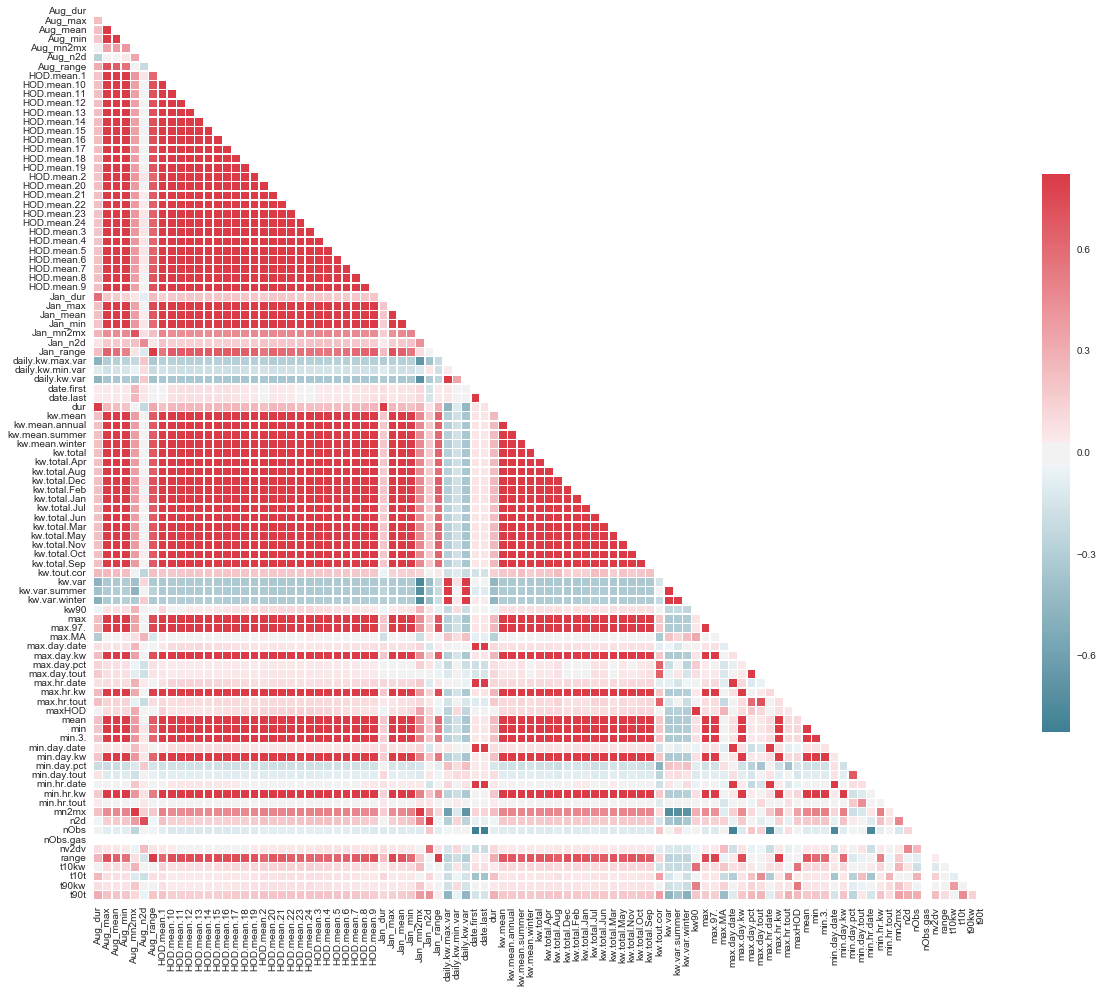

In [77]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax); #xticklabels=5, yticklabels=5,

In [79]:
all_features = all_features.T

In [83]:
all_features

,Aug_dur,Aug_max,Aug_mean,Aug_min,Aug_mn2mx,Aug_n2d,Aug_range,HOD.mean.1,HOD.mean.10,HOD.mean.11,...,mn2mx,n2d,nObs,nObs.gas,nv2dv,range,t10kw,t10t,t90kw,t90t
PrimClass_Everett,10.419355,3.362418,2.656481,2.112019,0.638665,0.892218,1.250399,1.924617,2.966085,3.012613,...,0.559682,0.813430,8784.0,0.0,0.298115,1.549035,11.0,12.0,15.0,13.0
UnivClass_Clifford,13.806452,1.578565,1.360954,1.092944,0.696614,0.815557,0.485621,1.304260,1.499826,1.551977,...,0.726873,0.846786,8760.0,0.0,0.790789,0.460169,14.0,1.0,15.0,13.0
Office_Elizabeth,10.903226,22.258194,12.088308,3.191204,0.209849,1.617178,19.066990,7.346055,14.851987,13.229716,...,0.237451,1.501214,8784.0,0.0,3.565031,13.596143,9.0,12.0,10.0,13.0
Office_Ellie,10.580645,27.189994,16.811948,7.530569,0.306260,1.346894,19.659424,8.683609,23.462749,21.963505,...,0.350027,1.651211,8784.0,0.0,12.162595,18.993940,6.0,15.0,10.0,17.0
PrimClass_Elisabeth,10.838710,19.052791,10.223555,2.770349,0.211510,0.349734,16.282442,4.838306,8.116702,10.082858,...,0.233893,0.450481,8784.0,0.0,0.010771,11.723329,16.0,12.0,15.0,13.0
Office_Cristina,11.258065,4.590605,3.059969,1.737960,0.385835,0.796620,2.852645,2.629548,3.852769,3.847447,...,0.406059,0.744392,8760.0,0.0,0.375168,2.860491,8.0,1.0,13.0,13.0
PrimClass_Jolie,9.677419,0.685419,0.441801,0.244387,0.404046,0.797499,0.441032,0.430966,1.878934,2.456092,...,0.261152,0.493790,8760.0,0.0,0.005113,2.821436,15.0,5.0,13.0,9.0
PrimClass_Jaylin,7.903226,1.247742,0.935618,0.755806,0.626471,0.947756,0.491935,1.166271,4.368223,4.420436,...,0.312562,0.809220,8760.0,0.0,0.057085,5.555318,13.0,5.0,13.0,9.0
Office_Jesus,8.032258,3.574806,2.742779,2.225774,0.633351,0.838616,1.349032,1.590508,2.212248,2.307878,...,0.502008,0.783314,8760.0,0.0,0.449426,1.380838,14.0,6.0,17.0,9.0
PrimClass_Esmeralda,10.000000,22.304564,18.649465,16.098213,0.734802,0.958706,6.206351,10.180013,17.327672,17.447771,...,0.562175,0.851558,8784.0,0.0,0.820851,8.896673,10.0,12.0,14.0,14.0


In [84]:
all_features.to_csv(os.path.join(repos_path,"data/processed/features_visdom.csv"))